# Method of simulated moments

Import the different libaries and the SMD module

In [1]:
from consav import runtools
runtools.write_numba_config(disable=0,threads=8)

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Local modules
from Model import RetirementClass
import funs
import figs
import SimulatedMinimumDistance as SMD

# Global modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Prep

Function to make moments for singles

In [2]:
def mom_fun(data,weights=False):
    
    # initialize
    states = np.unique(data.sim.states,axis=0)
    MA = data.sim.states[:,0]
    ST = data.sim.states[:,1]    
    T = data.par.simT
    N = len(states)
    probs = data.sim.probs
    mom = np.zeros((T,N))
    if weights:
        std = np.zeros((T,N))
    
    # compute moments
    for i in range(N):
        ma = states[i][0]
        st = states[i][1]
        mask = np.nonzero((MA==ma) & (ST==st))[0]
        mom[:,i] = np.nanmean(probs[:,mask]*100,axis=1)
        if weights:
            std[:,i] = np.nanstd(probs[:,mask]*100,axis=1)
            
    # return
    if weights:
        w = np.eye(std.size)*std.ravel()
        return mom.ravel(),w
    else:
        return mom.ravel()

Generate data

In [3]:
data_seed = 2019
data = RetirementClass(sim_seed=data_seed)
data.par.simT = 20
data.solve()
data.simulate()
mom_data,weight = mom_fun(data,weights=True)

Set up model for estimation

In [4]:
est_seed = 1000
model_base = RetirementClass(sim_seed = est_seed)
model_base.par.simT = 20

Set up estimation

In [10]:
# Parameters to be estimated (and guess)
true = [data.par.alpha_0_male, data.par.alpha_0_female, data.par.alpha_1, data.par.sigma_eta]
theta0 = [i*0.1 for i in true]
add_str = '_est'
est_par = ["alpha_0_male", "alpha_0_female", "alpha_1", "sigma_eta"]

# Setup estimation
smd_base = SMD.SimulatedMinimumDistance(model_base,mom_data,mom_fun,print_iter=[True,50],save=True,options={'disp':True})
smd_base.est_par = est_par
smd_base.est_par_save = {'{}'.format(i):[] for i in est_par}
smd_base.est_par_save['obj_func'] = []

Run estimation

In [11]:
tic = time.time()
smd_base.estimate(theta0,weight)
theta_base = smd_base.est
toc = time.time()

Iteration:  50
 alpha_0_male=0.052 alpha_0_female=-0.079 alpha_1=0.013 sigma_eta=0.563 -> 36594.8545
Iteration:  100
 alpha_0_male=0.242 alpha_0_female=-0.074 alpha_1=-0.013 sigma_eta=0.604 -> 25009.9056
Iteration:  150
 alpha_0_male=0.344 alpha_0_female=0.228 alpha_1=-0.180 sigma_eta=0.664 -> 8690.5879
Iteration:  200
 alpha_0_male=0.361 alpha_0_female=0.176 alpha_1=-0.114 sigma_eta=0.741 -> 6648.4346
Iteration:  250
 alpha_0_male=0.197 alpha_0_female=0.093 alpha_1=0.035 sigma_eta=0.427 -> 1511.4192
Iteration:  300
 alpha_0_male=0.174 alpha_0_female=0.130 alpha_1=0.046 sigma_eta=0.466 -> 201.9305
Iteration:  350
 alpha_0_male=0.173 alpha_0_female=0.130 alpha_1=0.046 sigma_eta=0.465 -> 193.4294
Iteration:  400
 alpha_0_male=0.173 alpha_0_female=0.130 alpha_1=0.046 sigma_eta=0.465 -> 202.9258
Iteration:  450
 alpha_0_male=0.173 alpha_0_female=0.130 alpha_1=0.046 sigma_eta=0.465 -> 192.6750
Iteration:  500
 alpha_0_male=0.173 alpha_0_female=0.130 alpha_1=0.046 sigma_eta=0.465 -> 192.6371

In [12]:
print('True:            ', np.round(true, 4))
print('Estimated:       ', np.round(theta_base, 4))
print('bias:            ', np.round(theta_base-true, 4))
print('Estimation time: ', round((toc-tic)/60,2), 'minutes')

True:             [0.16  0.119 0.053 0.435]
Estimated:        [0.1734 0.1304 0.0457 0.465 ]
bias:             [ 0.0134  0.0114 -0.0073  0.03  ]
Estimation time:  24.87 minutes


Plot the estimated model

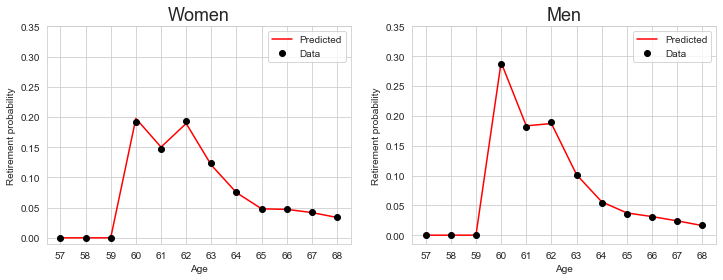

In [13]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
figs.retirement_probs(model_base,axs[0],ma=0)
figs.retirement_probs(model_base,axs[1],ma=1)
figs.retirement_probs(data,axs[0],ma=0,dots=True)
figs.retirement_probs(data,axs[1],ma=1,dots=True)
axs[0].set_title('Women',size=18)
axs[1].set_title('Men',size=18)
axs[0].legend()
axs[1].legend()
plt.show()

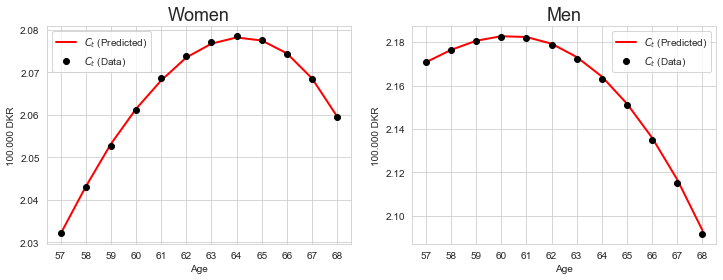

In [14]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
figs.lifecycle(model_base,axs[0],ma=0,vars=['c'])
figs.lifecycle(model_base,axs[1],ma=1,vars=['c'])
figs.lifecycle(data,axs[0],ma=0,vars=['c'],dots=True)
figs.lifecycle(data,axs[1],ma=1,vars=['c'],dots=True)
axs[0].set_title('Women',size=18)
axs[1].set_title('Men',size=18)
plt.show()

# Old

In [ ]:
# parameters to be estimated
#The "true values from the model"
true = [data.par.alpha_0_female]#, data.par.alpha_0_male, data.par.alpha_1]
#Our "guess" values
theta0 = [i*1.5 for i in true]
add_str = '_est'
est_par = ["alpha_0_female"]#, "alpha_0_male", "alpha_1") # remember to be list if only 1 var

#sim
smd_base = SMD.SimulatedMinimumDistance(model_base,mom_data,mom_fun,print_iter=True,save=True,options={'disp':True})
smd_base.est_par = est_par

#Creates the dictionary to which we save the output from estimation
smd_base.est_par_save = {'{}'.format(i):[] for i in est_par}
smd_base.est_par_save['obj_func'] = []

#run estimation
smd_base.estimate(theta0,weight)
theta_base = smd_base.est

theta_base - true

In [72]:
#finds obj_func value

def obj_print(dict_in):
    return dict_in['obj_func'].index(min(dict_in['obj_func']))
                                              
#smd_base.est_par_save['obj_func'].index((min(smd_base.est_par_save['obj_func'])))
#print(smd_base.est_par_save['alpha_0_female'][145])

Generate data

In [8]:
data = SingleClass(Na=190, poc=10, a_max=10, simN=40000, simT=20)
data.par.simStates = np.array(list(range(8))*5000)
data.solve()
data.simulate()

Generate moments

In [9]:
mom_data = mom_fun(data.sim)
weight = weight_fun(data.sim)

Estimate the baseline model

In [ ]:
model_base = SingleClass(Na=190, poc=10, a_max=10, simN=40000, simT=20)
model_base.par.simStates = np.array(list(range(8))*5000)
model_base.par.sim_seed = 2019
model_base._simulate_prep()

Check seed numbers form simulated data and model are not the same.

In [ ]:
# Different seeeds
print('data seed:',data.par.sim_seed)
print('estimation seed',model_base.par.sim_seed)

Jeg har indført et stykke kode SimulatedMinimumDistance.py - for at gemme objektiv funtionen og de forløbige estimater - det bruges så for at plotte estimeringen. 
Deruder har jeg indført et stykke kode i fig. for at plotte 3D grafer med de overstående lister.

# Estimate - without "multistart"

Setup for estimation

In [15]:
#The "true values from the model"
true = [data.par.alpha_0_female]#, data.par.alpha_0_male, data.par.alpha_1]
#Our "guess" values
theta0 = [i*1.5 for i in true]
add_str = '_est'
est_par = ["alpha_0_female"]#, "alpha_0_male", "alpha_1") # remember to be list if only 1 var

Estimation

In [ ]:
#sim
smd_base = SMD.SimulatedMinimumDistance(model_base,mom_data,mom_fun,print_iter=True,save=True,options={'disp':True})
smd_base.est_par = est_par

#Creates the dictionary to which we save the output from estimation
smd_base.est_par_save = {'{}'.format(i):[] for i in est_par}
smd_base.est_par_save['obj_func'] = []

#run estimation
smd_base.estimate(theta0,weight)
theta_base = smd_base.est

theta_base - true

# "Multistart" estimation

Setup for estimation

In [ ]:
# prep
true = [model.par.alpha_0_female, model.par.alpha_1]#, model.par.alpha_2]
theta0 = [i*3 for i in true]
add_str = '_est'
est_par = ["alpha_0_female", "alpha_1"]#, "alpha_2") # remember to be list if only 1 var
est_par_g = {"alpha_0_female":[0,1], "alpha_1":[0,1]}#, "alpha_2":[3,4]}



Estimation

In [26]:
#sim
smd_base = SMD.SimulatedMinimumDistance(model_base,mom_data,mom_fun,print_iter=True,save=True,options={'disp':True})
smd_base.est_par = est_par

#Creates a list with a number of starting values for each parameter. 
guess = smd_base.multistart_V(2,est_par_g)

#Creates the dict to save output from estimation
smd_base.est_par_save = {'{}'.format(i):[] for i in est_par}
smd_base.est_par_save['obj_func'] = []

#Run estimation
smd_base.multistart_estimate(guess,weight)
theta_base = smd_base.est


 alpha_0_female=0.949 alpha_1=0.903 -> 62729.6363
 alpha_0_female=0.997 alpha_1=0.903 -> 63846.2721
 alpha_0_female=0.949 alpha_1=0.948 -> 63574.0535
 alpha_0_female=0.902 alpha_1=0.948 -> 62525.4055
 alpha_0_female=0.854 alpha_1=0.971 -> 62115.1126
 alpha_0_female=0.854 alpha_1=0.926 -> 60924.3106
 alpha_0_female=0.807 alpha_1=0.914 -> 59344.4391
 alpha_0_female=0.712 alpha_1=0.982 -> 58465.6245
 alpha_0_female=0.593 alpha_1=1.022 -> 55319.3171
 alpha_0_female=0.546 alpha_1=0.965 -> 50265.0168
 alpha_0_female=0.392 alpha_1=0.962 -> 41291.0332
 alpha_0_female=0.178 alpha_1=1.070 -> 37877.3996
 alpha_0_female=-0.136 alpha_1=1.147 -> 48796.3091
 alpha_0_female=-0.024 alpha_1=1.010 -> 37568.8225
 alpha_0_female=-0.332 alpha_1=1.005 -> 42874.8284
 alpha_0_female=-0.237 alpha_1=1.118 -> 49248.3883
 alpha_0_female=0.234 alpha_1=1.001 -> 36144.1330
 alpha_0_female=0.033 alpha_1=0.942 -> 33024.6508
 alpha_0_female=-0.040 alpha_1=0.878 -> 33601.8280
 alpha_0_female=0.291 alpha_1=0.933 -> 35324.

# Figures

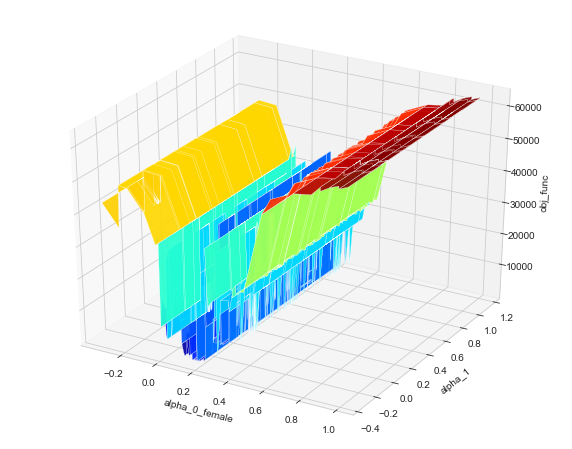

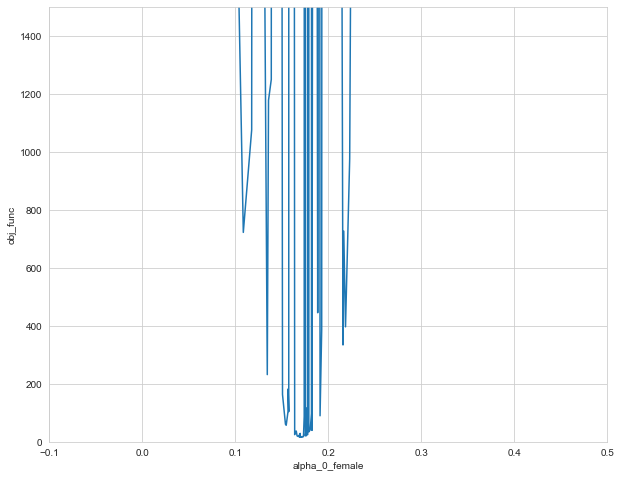

In [95]:
fig1 = figs.plot_3DD(smd_base.est_par_save,'alpha_0_female','alpha_1','obj_func')
#fig2 = figs.plot_3D(smd_base.est_par_save,'alpha_1','alpha_0_female','obj_func')
#fig3 = figs.plot_3D(smd_base.est_par_save,'alpha_1','obj_func','alpha_0_female')
#fig4 = figs.plot_3D(smd_base.est_par_save,'obj_func','alpha_0_female','alpha_1')

figs.plot_2DD(smd_base.est_par_save,'alpha_0_female','obj_func',[-0.1,0.5],[0,1500])